<center><font size=5> <b> SMU Homework 8 - MSDS7337 - Natural Language Processing </b> </font>
<br><br><br>
<center><font size=4> <b> Spring 2021  Ikenna Nwaogu </b></font> 




<img src="https://cdn.searchenginejournal.com/wp-content/uploads/2020/08/an-introduction-to-natural-language-processing-with-python-for-seos-5f3519eeb8368-760x400.webp"> 
<br>
<p align="center"><font size=4> <b><center> IMDB Movie Review Sentiment Analysis  </b></font> </p>

### BeautifulSoup Implementation
<br>
Below we used Beautiful soup to grab the main review text from 50 movie links in the "Drama" Genre of the IMDB movie website. For every movies, we took the top positive and negative review. <br><br>
 

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from requests import get

import nltk
from nltk.corpus import stopwords

#url = 'https://www.imdb.com/list/ls095374765/?sort=list_order,asc&st_dt=&mode=grid&page=1&ref_=ttls_ref_gnr&genres=Drama'
url = 'https://www.imdb.com/list/ls095374765/?sort=moviemeter,asc&st_dt=&mode=grid&page=1&ref_=ttls_vw_smp&genres=Drama'
response = get(url)
html_soupMain = BeautifulSoup(response.text, 'html.parser')


In [2]:
movieReview = []
reviewTitle = []
movieTitle = []

##### <br>We will get the remaining 4 movies from the next page(Page 2) and append it to the previous 96. <br> Below picks top positive and negative reviews in a movie review page.

In [3]:
def list_Of_Reviews(website):
    soup = BeautifulSoup(website, 'html.parser')
    # print(soup)
    f = soup.find_all('div', class_='ipl-icon ipl-star-icon')
    f = soup.find_all('span', class_="rating-other-user-rating")#.find('span').text

    idxPos = -1
    idxNeg = -1

    for idx, i in enumerate(f):
        sp = (f[idx].text.split('/'))
        sp = int(sp[0][-2:])
        if sp > 8:
            idxPos = idx
        elif sp < 4:
            idxNeg = idx
    return([idxNeg,idxPos])

Bellow shows how beautifulsoup was able to parse and get the movie title and the review title. We will use both information in displaying the reviews. As stated above we will have 2 reviews per movie, positive and negative reviews. I wonder if the cluster would be able to cluster the reviews of same movie together in one cluster or whether some negative comments would cluster similarly. We also did a lemantization using nltk.

In [4]:
stop_words = set(stopwords.words("english"))
for div in html_soupMain.findAll('div', attrs={'class':'title'}):
    if len(movieReview) > 98:
        break
    else:
        url = 'https://www.imdb.com' + div.find('a')['href'] 
        url = url + 'reviews'
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        review_containers = html_soup.find_all('div', class_='text show-more__control')
        title_containers = html_soup.find_all( class_='title')
        
        reviewIndex = list_Of_Reviews(response.content)
        reviewList = []

        if reviewIndex[0] == -1 or reviewIndex[1] == -1:
            pass
        else:
            reviewList.append(review_containers[reviewIndex[0]].text)
            reviewList.append(review_containers[reviewIndex[1]].text)
            reviewTitle.append(title_containers[reviewIndex[0]].string + ' -')
            reviewTitle.append(title_containers[reviewIndex[1]].string + ' +')
            movieTitle.append(div.string + ' -')
            movieTitle.append(div.string + ' +')
            count =+ 2
            for i in reviewList:
                review = i.lower()
                #remove punctuation
                review = re.sub('[^a-zA-Z]', ' ', review)
                
                #remove tags
                review = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",review)

                #remove special characters and digits
                review = re.sub("(\\d|\\W)+"," ",review)

                split_text = review.split()
                 
                split_text = " ".join(split_text)
                movieReview.append(split_text)


Each movie title and review title is tagged with a positive or negative in the end so to differentiate each review.

In [5]:
print(len(movieReview))

100


### Vectorize Reviews using TF-IDF
We vectorize the movie review list using tf-idf. In this analysis we would remove stop words so that it doesnt possibly interfere with the polarity score.

In [8]:
#TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(stop_words = {'english'})#stop_words, ngram_range = (1,1))#transform
vec_text = tfv.fit_transform(movieReview)#returns a list of words.
words = tfv.get_feature_names()

To decide what the number of k clusters, we implore the elbow method which consists of pllotting  different variations as a function of  a certain number of cluster which we would provive. We chose to tryk from 2 to 9.

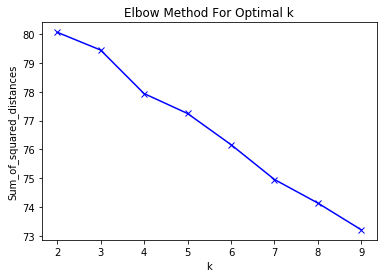

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
X = vec_text
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Above shows sum of square distance that is slightly straight line but shows a bit of convergeance around 4 so we would use k of 6. We allow k to be altered up to 10 with n_init = 10. we allowed tolerance of 0.001 and max iteration of 200.

In [10]:
import pandas as pd
true_k = 4
model = KMeans(n_clusters=true_k, max_iter=200, n_init=10, n_jobs = -1, tol = 0.001)
model.fit(X)
labels=model.labels_
reviews_cl=pd.DataFrame(list(zip(movieTitle, reviewTitle,labels)),columns=['Movie','Review title','cluster'])
reviews_cl.sort_values(by=['cluster'])


,Movie,Review title,cluster
86,Geronimo: An American Legend -,Nice Attempt ... missed opportunity\n -,0
42,Malcolm X -,"Good film, but way too long\n -",0
15,Immortals +,You wont regret it\n +,0
43,Malcolm X +,Horribly racist movie. It actually caused mil...,0
70,Out of Time -,Old Film Noir plot??\n -,0
...,...,...,...
28,The Twilight Saga: Eclipse -,Bland and boring.\n -,3
30,The Twilight Saga: Breaking Dawn - Part 1 -,50 minute wedding followed by 50 minutes of b...,3
34,The Man in the Iron Mask -,Another bad Dumas adaptation\n -,3
46,Deadwood: The Movie -,How can anyone like this!!\n -,3


In [11]:
common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


0 : the, to, was, he, of, and, that, this, it, you
1 : the, and, of, to, is, in, it, movie, this, that
2 : the, to, and, of, is, in, that, his, as, it
3 : the, and, it, of, to, is, this, movie, was, in


Above shows some of the common words that were used to cluster.

Cluster: 0
Review Titles
 Extremely Wicked, Shockingly Evil and Vile -
                                  Immortals +
                                  Malcolm X -
                                  Malcolm X +
                               Batman: Hush -
                A Walk Among the Tombstones -
                                   J. Edgar +
                                         IO -
                                Out of Time -
                              The Hurricane +
                                Final Score -
                                Final Score +
               Geronimo: An American Legend -
                                    Gundala +


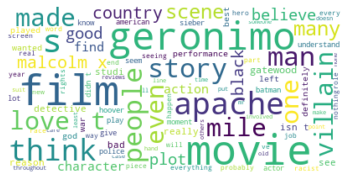

Cluster: 1
Review Titles
                                     Glass -
                                  Twilight +
                                      Argo -
                                      Argo +
                               The Aviator -
                               The Patriot -
                               The Patriot +
                           The Hurt Locker -
                The Twilight Saga: Eclipse +
 The Twilight Saga: Breaking Dawn - Part 1 +
                        The Bone Collector +
                  The Man in the Iron Mask +
                        Enemy at the Gates -
                        Enemy at the Gates +
               The Twilight Saga: New Moon -
               The Twilight Saga: New Moon +
                              Body of Lies -
                              Body of Lies +
                       Deadwood: The Movie +
                              Batman: Hush +
                               He Got Game -
                        The Gr

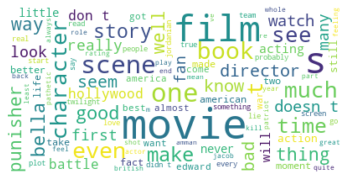

Cluster: 2
Review Titles
                             The Aviator +
                         The Hurt Locker +
                     The Next Three Days -
                      The Lost City of Z -
                      The Lost City of Z +
                  Brawl in Cell Block 99 -
                      The Bone Collector -
                           State of Play -
                           State of Play +
                Batman: The Killing Joke -
                Batman: The Killing Joke +
             A Walk Among the Tombstones +
                                  John Q +
 Batman: The Dark Knight Returns, Part 1 -
 Batman: The Dark Knight Returns, Part 1 +
                             He Got Game +
                          Antwone Fisher -
                             Out of Time +
                        Batman: Year One -
                             All the Way -
                         Too Big to Fail -
                         Too Big to Fail +
         Superman/Batman: Pub

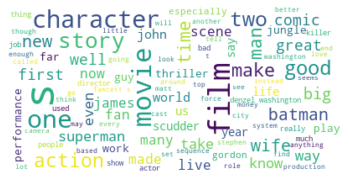

Cluster: 3
Review Titles
                                      Glass +
                               Cold Pursuit -
                               Cold Pursuit +
                                   Twilight -
                               Pearl Harbor -
                               Pearl Harbor +
 Extremely Wicked, Shockingly Evil and Vile +
                                  Immortals -
                        The Next Three Days +
                                     Flight -
                                     Flight +
                     Brawl in Cell Block 99 +
                 The Twilight Saga: Eclipse -
  The Twilight Saga: Breaking Dawn - Part 1 -
                   The Man in the Iron Mask -
                        Deadwood: The Movie -
                                   J. Edgar -
                                     John Q -
                                         IO +
                                 Pathfinder -
                                 Pathfinder +
         

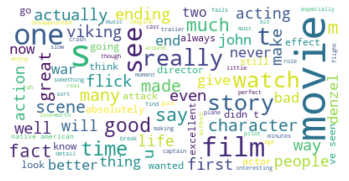

In [12]:
from wordcloud import WordCloud
result={'cluster':labels,'Movie Reviews':movieReview}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['Movie Reviews'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Review Titles')
    movieTitles=reviews_cl[reviews_cl.cluster==k]['Movie']    
    #reviewTitles=reviews_cl[reviews_cl.cluster==k]['Review title'] 
    print(movieTitles.to_string(index=False))#,reviewTitles.to_string(index=False))
    #print(reviewTitles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Sentiment Analysis 
For the reviews of the 4 clusters we generated above. We use VADER from NLTK because it is useful for non-formal and short documents or texts. In this analysis we would remove stop words so that it doesnt possibly interfere with the polarity score. We will also tockenize each review using nltk.

In [13]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
SentiAnalyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ikenna/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
stopWords = stopwords.words("english")
stopWords.extend([w.lower() for w in nltk.corpus.names.words()])

In [16]:
from statistics import mean, median

def polarity_score(review):
    scores = [
      SentiAnalyzer.polarity_scores(sentence)["compound"]
        for sentence in [w for w in nltk.sent_tokenize(review) if not w in stopWords]
    ]
    return mean(scores)

In [17]:
polarity_score('pete became news yesterday but sad to make angry')

-0.8625

In [18]:
polarityScore = []
for review in movieReview:
    score = polarity_score(review)
    polarityScore.append(score)

In [19]:
result['Score'] = polarityScore
print(result)

    cluster                                      Movie Reviews   Score
0         1  so first of all i like thoughtful movies but a... -0.9841
1         3  at about fifteen minutes in i was ready to wal...  0.9807
2         3  simply see original norwegian film in order of... -0.8783
3         3  it s really funny and action a perfect combina...  0.7841
4         3  growing up i always refused to watch this like...  0.8563
..      ...                                                ...     ...
95        2  mr van damme gives an oscar performance no way... -0.9771
96        3  i m super emotional because gundala is like an...  0.9423
97        0  this movie is so cool i love all the plot twis...  0.9800
98        2  ok i m a big superman fan and for that matter ... -0.9167
99        2  it s funny really about two years ago when ser...  0.9853

[100 rows x 3 columns]


In [20]:
cluster_Scores = result[['cluster','Score']]
cluster_Group_Scores = cluster_Scores.groupby("cluster").agg({'Score': ['mean', 'median', 'min', 'max']})
print(cluster_Group_Scores)

            Score                         
             mean   median     min     max
cluster                                   
0        0.159650  0.36320 -0.9897  0.9969
1        0.176279  0.57410 -0.9972  0.9990
2        0.391950  0.95205 -0.9980  0.9990
3        0.413696  0.80200 -0.9945  0.9945


### Conclusion
Looking at the scores above, you can see that the 4 clusters all have both negative and positive sentiments. This makes sense because we have both positive and negative reviews. When we look at just the mean we can se that cluster 2 and cluster 3 has mostly positive sentiments. Another interesting statistics is the median for all shows mostly positive sentiment with cluster 2 having the most positive sentiment. All clusters have similar min and max scores which represents the cluster well since we have both negative and positve reviews in each one of the clusters.

### Extra Credit

In [53]:
NP_Chunker = []
for div in html_soupMain.findAll('div', attrs={'class':'title'}):
    if len(NP_Chunker) > 98:
        break
    else:
        url = 'https://www.imdb.com' + div.find('a')['href'] 
        url = url + 'reviews'
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        review_containers = html_soup.find_all('div', class_='text show-more__control')

        reviewIndex = list_Of_Reviews(response.content)
        reviewList = []

        if reviewIndex[0] == -1 or reviewIndex[1] == -1:
            pass
        else:
            reviewList.append(review_containers[reviewIndex[0]].text)
            reviewList.append(review_containers[reviewIndex[1]].text)
            count =+ 2

            for i in reviewList:
                text = nltk.word_tokenize(i)
                sentenceTag = nltk.pos_tag(text)
                POS_Tagger.append(sentenceTag)
                # Using RegexParser 
                grammar = "NP: {<DT>?<JJ>*<NN>}"

                cp = nltk.RegexpParser(grammar)
                result = cp.parse(sentenceTag)
                NP_Chunker.append(result)

In [59]:
print(len(NP_Chunker)) 

100


In [63]:
polarityScoreChunker = []
# for review in NP_Chunker:
#     score = polarity_score(review)
#     polarityScoreChunker.append(score)
print(NP_Chunker[1])

Am having issues running sentiment on Chunker because the ouput of the chunker is not in a list format. Couldn't find a way to iterate through each chunk and possible chunks to avoid when running the analysis.